# Exploração e análise de dados de crédito com SQL (Bônus Python)

## Introdução

Este projeto consiste na análise de um conjunto de dados (dataset) relacionado a operações de crédito, possivelmente originário do setor bancário - embora não tenha sido fornecido diretamente por nenhuma instituição financeira. A abordagem metodológica seguiu as seguintes etapas:

Inicialmente, trabalhou-se com uma amostra equivalente a 25% do dataset total, processada na plataforma AWS. Esta decisão inicial visava otimizar os custos computacionais, considerando que o processamento de grandes volumes de dados pode gerar despesas significativas.

Durante a fase de análise exploratória, identificamos potenciais inconsistências e riscos de viés amostral decorrentes do uso de apenas uma parcela dos dados. Para garantir a robustez dos resultados, optou-se então por realizar a análise completa do dataset. Visando manter a eficiência econômica, todo o processamento dos dados completos foi realizado utilizando ferramentas baseadas em Python.

Esta abordagem nos permite apresentar conclusões mais confiáveis e representativas, obtidas a partir da totalidade dos dados disponíveis para análise.

## TLDR

 - **Processamento**:
  - Kaggle Notebook ([link](https://www.kaggle.com/code/thiagomartinslk/aws-e-python-projeto-credito)).
 - **Fontes**:
  - Professor Andre Marcos Perez ([link](https://github.com/andre-marcos-perez/ebac-course-utils/tree/main/dataset));


# AWS Athena

## Criação e Informação da Tabela


**Os dados**: Os dados representam informações de clientes de um banco e contam com as seguintes colunas:

*  **idade** = idade do cliente
*  **sexo** = sexo do cliente (F ou M)
*  **dependentes** = número de dependentes do cliente
*  **escolaridade** = nível de escolaridade do clientes
*  **salario_anual** = faixa salarial do cliente
*  **tipo_cartao** = tipo de cartao do cliente
*  **qtd_produtos** = quantidade de produtos comprados nos últimos 12 meses
*  **iteracoes_12m** = quantidade de iterações/transacoes nos ultimos 12 meses
*  **meses_inativo_12m** = quantidade de meses que o cliente ficou inativo
*  **limite_credito** = limite de credito do cliente
*  **valor_transacoes_12m** = valor das transações dos ultimos 12 meses
*  **qtd_transacoes_12m** = quantidade de transacoes dos ultimos 12 meses

A tabela foi criada no AWS Athena junto com o S3 Bucket com uma versão  reduzida (aproximadamente um quarto) dos dados disponibilizados em: https://github.com/andre-marcos-perez/ebac-course-utils/tree/main/dataset

```sql
CREATE EXTERNAL TABLE IF NOT EXISTS `default`.`cretido_pessoal` (
  `idade` tinyint,
  `sexo` string,
  `dependentes` tinyint,
  `escolaridade` string,
  `estado_civil` string,
  `salario_anual` string,
  `tipo_cartao` string,
  `qtd_produtos` bigint,
  `iteracoes_12m` int,
  `meses_inativo_12m` int,
  `limite_cretido` double,
  `valor_transacoes_12m` double,
  `qtd_trasacoes_12m` int
)
ROW FORMAT SERDE 'org.apache.hadoop.hive.serde2.lazy.LazySimpleSerDe'
WITH SERDEPROPERTIES ('field.delim' = ',')
STORED AS INPUTFORMAT 'org.apache.hadoop.mapred.TextInputFormat' OUTPUTFORMAT 'org.apache.hadoop.hive.ql.io.HiveIgnoreKeyTextOutputFormat'
LOCATION 's3://bucket-thiago-projeto/'

```

Vamos consultar a descrição da tabela para verificar se ela foi criada corretamente.


```sql
DESCRIBE cretido_pessoal
```

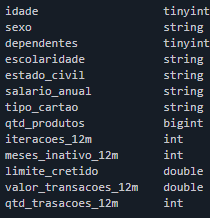

## Exploração dos Dados AWS


**Tamanho da Tabela**

```sql

SELECT COUNT(*) AS tamanho_tabela

FROM cretido_pessoal

 ```
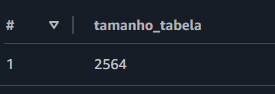

> **Observação:**  
> A base de dados disponibilizada no link acima possui mais registros do que a amostra utilizada neste notebook.  
>
> A base original contém 10.128 linhas, e você pode optar por utilizá-la integralmente ou trabalhar com uma fração dos dados.  
>
> Na prática, quanto maior a quantidade de dados analisada, mais confiáveis tendem a ser os resultados.  
>
> No entanto, é importante considerar as limitações computacionais e financeiras envolvidas. Por esse motivo, a redução do volume de dados pode ser uma estratégia válida para fins de estudo.


**Pessoas por cada nivel de cartão e sexo**

```sql

SELECT ROUND(AVG(idade), 2) AS media_idade, MAX(idade) AS max_idade, MIN(idade) AS min_idade, sexo, tipo_cartao
FROM cretido_pessoal
GROUP BY sexo, tipo_cartao
ORDER BY tipo_cartao, sexo

```

Iniciaremos analisando as idades (máxima, mínima e média) dos clientes, segmentadas por sexo e nível do cartão, a fim de obter uma visão geral da base de dados.

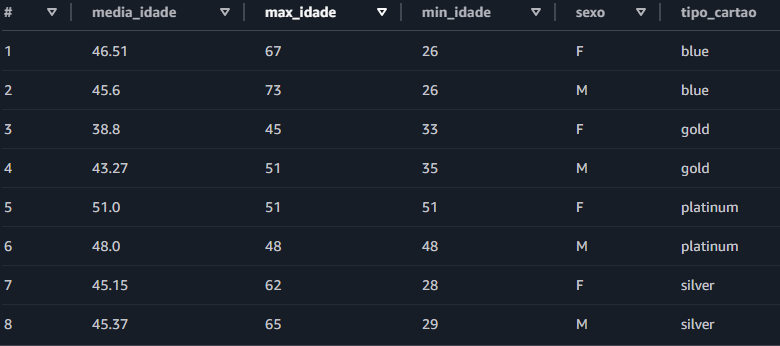

Observamos que o nível Platinum apresenta valores mínimos, máximos e médios de idade iguais.
A que será que isso se deve? Vamos verificar a quantidade de clientes por nível de cartão para investigar melhor.

```sql
SELECT tipo_cartao, COUNT(sexo) AS quantidade_pessoas
FROM cretido_pessoal
GROUP BY tipo_cartao

```

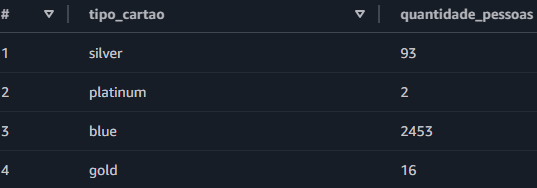

O nível Platinum possui apenas dois indivíduos (um homem e uma mulher). Portanto, passaremos a desconsiderá-los nas próximas consultas. No entanto, antes disso, vamos verificar se existe algum padrão específico entre esses dois clientes.

```sql
SELECT *
FROM cretido_pessoal
WHERE tipo_cartao = 'platinum'
```

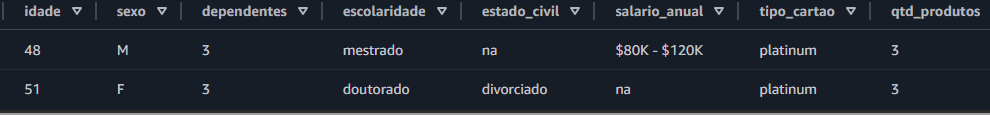

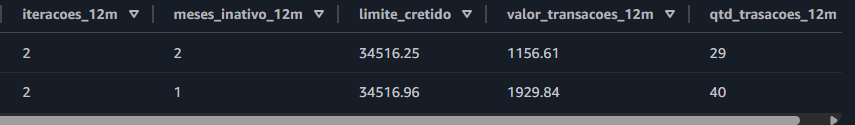

Podemos observar que ambos possuem idades próximas, nível elevado de escolaridade e limite de crédito igual. Vamos compará-los com os clientes do nível Gold para verificar se há alguma similaridade, desconsiderando os clientes com dados nulos de escolaridade.

```sql
SELECT idade, sexo, escolaridade, salario_anual, tipo_cartao, limite_cretido
FROM cretido_pessoal
WHERE tipo_cartao = 'gold' AND escolaridade != 'na'
LIMIT 10
```

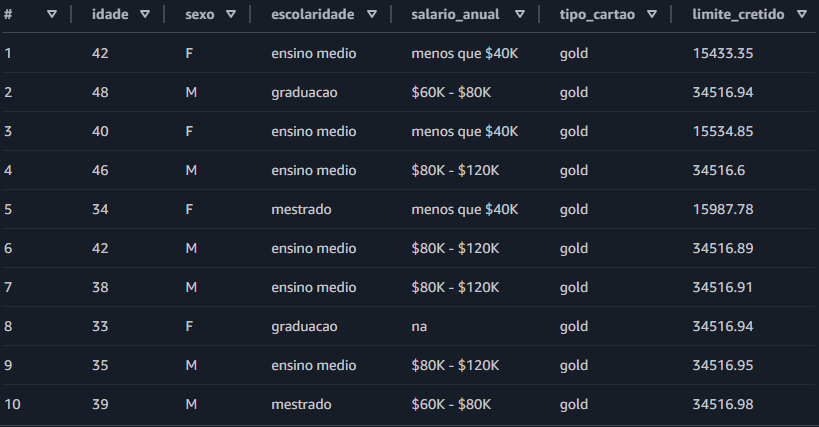

Com as últimas consultas, pudemos observar que um limite de crédito elevado não é uma exclusividade do nível Platinum. No entanto, esse perfil geralmente está associado a uma renda anual superior a $60 mil. O cliente com dado nulo de renda possivelmente é empresário, optou por não informar a renda ou trata-se de um outlier.
Vamos verificar se esse padrão se repete?

```sql
SELECT idade, sexo, escolaridade, salario_anual, tipo_cartao, limite_cretido
FROM cretido_pessoal
WHERE salario_anual = 'na' AND limite_cretido > 30000

```

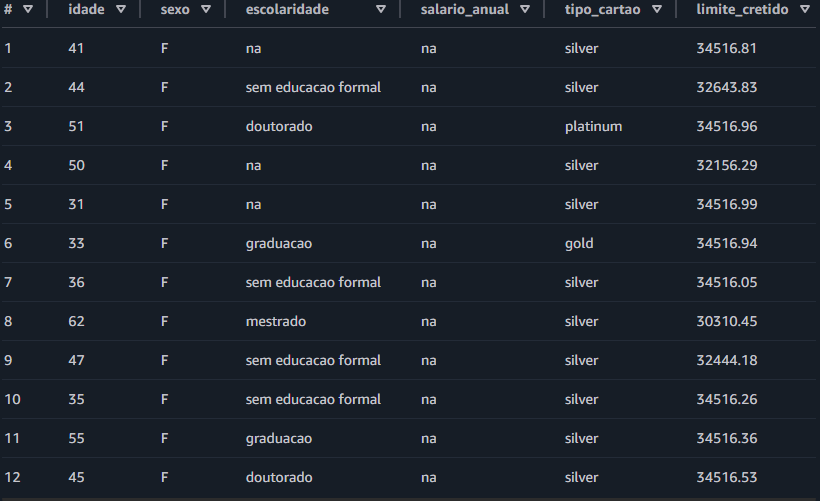

Em um conjunto de dados com 2.564 linhas, 12 registros podem parecer pouco significativos à primeira vista. No entanto, chama a atenção o fato de que 10 de 12 pertencerem ao nível Silver, várias dessas pessoas não possuírem educação formal registrada e todas serem do sexo feminino.

Isso nos leva a refletir: por que há tantos registros com essas características específicas? Existe algum padrão de concessão de crédito ou de preenchimento dos dados que justifique isso?

Vamos analisar as demais colunas para tentarmos identificar um possível motivo por trás desse padrão.


```sql
SELECT  escolaridade, tipo_cartao, limite_cretido, dependentes, meses_inativo_12m, qtd_trasacoes_12m, valor_transacoes_12m
FROM cretido_pessoal
WHERE salario_anual = 'na' AND limite_cretido > 30000
```

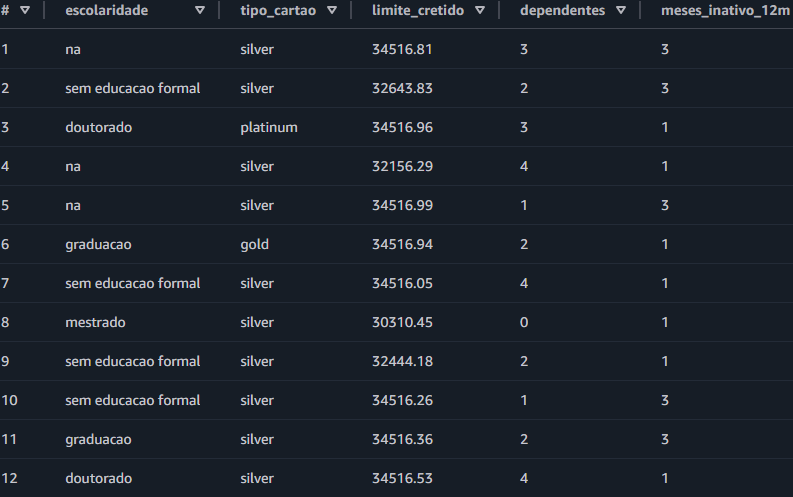

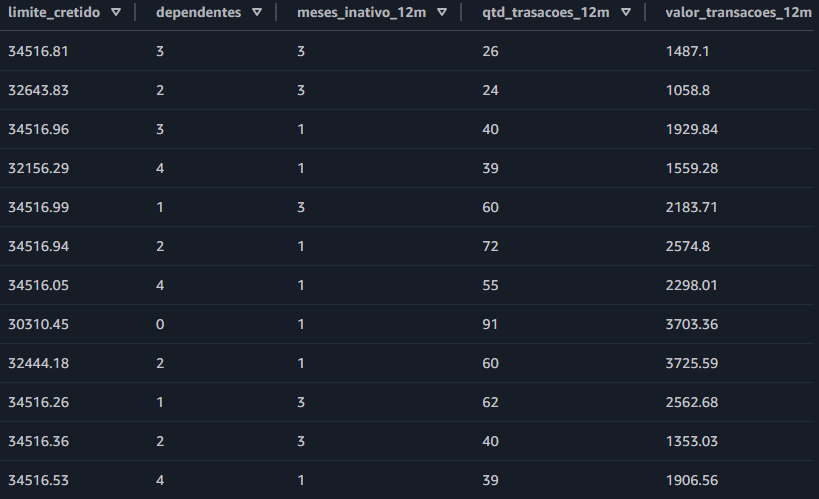

Todos os clientes estão inativos há entre 1 e 3 meses e, nos últimos 12 meses, gastaram pelo menos R$1.000 com o cartão. Quanto mais observamos, mais parece se tratar de um outlier.

Vamos expandir a análise e comparar esses resultados com o restante dos dados, a fim de identificar se o padrão observado se repete em outros perfis de clientes ou se trata, de fato, de um caso atípico (outlier).

Inicialmente, vamos analisar a média do limite de crédito e dos gastos dos clientes para termos uma visão geral do comportamento financeiro presente no conjunto de dados.


```sql
SELECT ROUND(AVG(limite_cretido), 2) AS media_cretido, ROUND(AVG(valor_transacoes_12m), 2) AS media_gastos
FROM cretido_pessoal
```

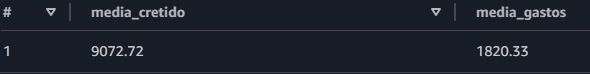

Podemos observar que a média do limite de crédito está significativamente abaixo da consulta anterior. No entanto, a média de gastos permanece próxima do esperado, com apenas alguns clientes ultrapassando essa média — ainda assim, os valores continuam muito abaixo do limite de crédito disponível para eles.

A seguir, vamos analisar os 10 primeiros clientes com os menores limites de crédito e verificar se os seus gastos estão compatíveis com esses limites.

```sql
SELECT limite_cretido, valor_transacoes_12m, tipo_cartao, sexo,
CASE
    WHEN limite_cretido > valor_transacoes_12m THEN 'Sob gasto'
    WHEN limite_cretido < valor_transacoes_12m THEN 'Sobre gasto'
END AS limite_gasto
FROM cretido_pessoal
ORDER BY limite_cretido
LIMIT 10
```

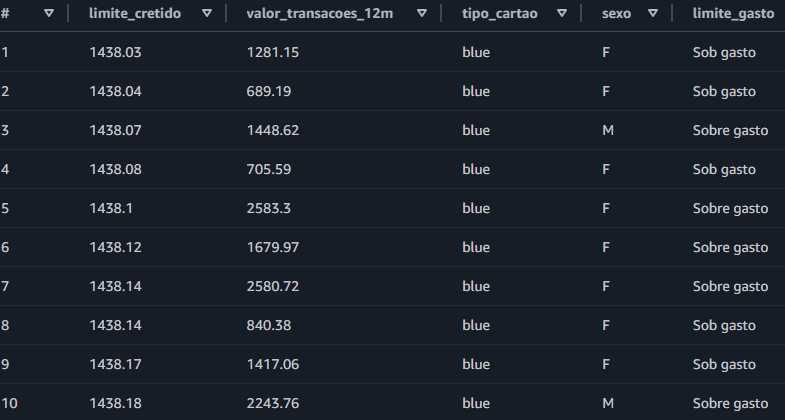

Como já era de se imaginar, todos os clientes com os menores limites de crédito pertencem ao nível Blue. No entanto, cinco dos dez gastaram um valor superior ao seu limite de crédito, o que é preocupante. Também observamos que oito desses dez clientes são mulheres — mais uma vez, as mulheres se destacam nessa análise. Será que a maioria dos clientes no nosso dataset é composta por mulheres? Vamos investigar.


```sql
SELECT sexo, COUNT(sexo) AS quantidade
FROM cretido_pessoal
GROUP BY sexo
```

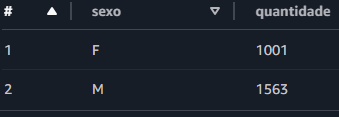

A resposta é não... Provavelmente, essa impressão ocorre porque estamos utilizando apenas um quarto do dataset original.

Vamos verificar quantas pessoas de cada sexo estão nas categorias de "Sob gasto" e "Sobre gasto".


```sql
SELECT sexo,
    CASE
        WHEN limite_cretido > valor_transacoes_12m THEN 'Sob gasto'
        WHEN limite_cretido < valor_transacoes_12m THEN 'Sobre gasto'
    END AS limite_gasto,
    COUNT(sexo) AS quantidade
FROM cretido_pessoal
GROUP BY
    sexo,
    CASE
        WHEN limite_cretido > valor_transacoes_12m THEN 'Sob gasto'
        WHEN limite_cretido < valor_transacoes_12m THEN 'Sobre gasto'
    END
ORDER BY sexo
```

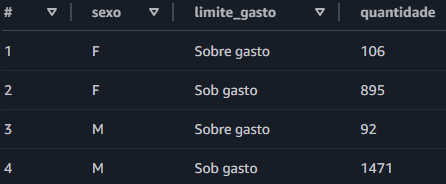

Felizmente, não há muitas pessoas com "sobre gasto". Vamos agora analisar essa condição com base no nível do cartão?

```sql
SELECT tipo_cartao,
    CASE
        WHEN limite_cretido > valor_transacoes_12m THEN 'Sob gasto'
        WHEN limite_cretido < valor_transacoes_12m THEN 'Sobre gasto'
    END AS limite_gasto,
    COUNT(tipo_cartao) AS quantidade
FROM cretido_pessoal
GROUP BY
    tipo_cartao,
    CASE
        WHEN limite_cretido > valor_transacoes_12m THEN 'Sob gasto'
        WHEN limite_cretido < valor_transacoes_12m THEN 'Sobre gasto'
    END
ORDER BY tipo_cartao
```

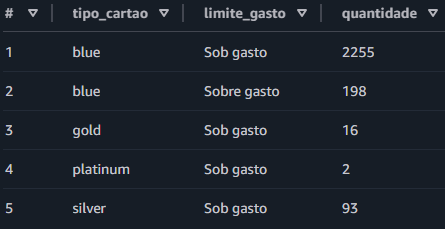

Como era de se esperar, apenas clientes do nível Blue apresentam sobre gasto, porém em pequena quantidade.

Vamos tentar visualizar o dataset completo para verificar se os insights anteriores estavam corretos ou se foram influenciados pelo uso de apenas um quarto da base de dados.

A partir de agora, utilizaremos Python para continuar a análise, devido ao motivo mencionado anteriormente na seção de Exploração dos Dados AWS, na Observação.



# Python

## Modelagem dos Dados

Download do dataset.

In [ ]:
!wget -q https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/refs/heads/main/dataset/credito.csv

Importação das bibliotecas que serão utilizadas.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Vamos iniciar o DataFrame abrindo o arquivo CSV com `with open` e, em seguida, criando o DataFrame. Isso é necessário porque o arquivo original é separado por vírgulas (",") e, nas colunas `limite_credito` e `valor_transacoes_12m`, os valores estão formatados no padrão do Real brasileiro (por exemplo, 12.691,51), onde a vírgula é usada como separador decimal. Essa formatação pode causar erros ao criar o DataFrame diretamente, por isso é importante tratar os dados antes.

In [ ]:
with open('credito.csv', 'r', encoding='utf8', ) as fp:
  df = pd.read_csv(fp, sep=',', encoding='utf-8')

Nas colunas `limite_credito` e `valor_transacoes_12m` podemos observar erros de formatação. Portanto, antes de iniciar a análise, é necessário realizar o tratamento desses dados.

In [ ]:
df.head()

,id,default,idade,sexo,dependentes,escolaridade,estado_civil,salario_anual,tipo_cartao,meses_de_relacionamento,qtd_produtos,iteracoes_12m,meses_inativo_12m,limite_credito,valor_transacoes_12m,qtd_transacoes_12m
0,768805383,0,45,M,3,ensino medio,casado,$60K - $80K,blue,39,5,3,1,"12.691,51","1.144,90",42
1,818770008,0,49,F,5,mestrado,solteiro,menos que $40K,blue,44,6,2,1,"8.256,96","1.291,45",33
2,713982108,0,51,M,3,mestrado,casado,$80K - $120K,blue,36,4,0,1,"3.418,56","1.887,72",20
3,769911858,0,40,F,4,ensino medio,na,menos que $40K,blue,34,3,1,4,"3.313,03","1.171,56",20
4,709106358,0,40,M,3,sem educacao formal,casado,$60K - $80K,blue,21,5,0,1,"4.716,22","816,08",28


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   id                       10127 non-null  int64 
 1   default                  10127 non-null  int64 
 2   idade                    10127 non-null  int64 
 3   sexo                     10127 non-null  object
 4   dependentes              10127 non-null  int64 
 5   escolaridade             10127 non-null  object
 6   estado_civil             10127 non-null  object
 7   salario_anual            10127 non-null  object
 8   tipo_cartao              10127 non-null  object
 9   meses_de_relacionamento  10127 non-null  int64 
 10  qtd_produtos             10127 non-null  int64 
 11  iteracoes_12m            10127 non-null  int64 
 12  meses_inativo_12m        10127 non-null  int64 
 13  limite_credito           10127 non-null  object
 14  valor_transacoes_12m     10127 non-nul

As colunas `limite_credito` e `valor_transacoes_12m` estão tipadas como object (string). Para corrigir, vamos remover os pontos (".") que indicam milhares e substituir a vírgula (",") decimal por ponto ("."), para então convertê-las corretamente para o tipo float.

In [ ]:
df['limite_credito'] = df['limite_credito'].str.replace('.', '', regex=False)  # Remove milhar
df['valor_transacoes_12m'] = df['valor_transacoes_12m'].str.replace('.', '', regex=False)  # Remove milhar
df['limite_credito'] = df['limite_credito'].str.replace(',', '.', regex=False)  # Troca decimal
df['valor_transacoes_12m'] = df['valor_transacoes_12m'].str.replace(',', '.', regex=False)  # Troca decimal
df['limite_credito'] = df['limite_credito'].astype(float)
df['valor_transacoes_12m'] = df['valor_transacoes_12m'].astype(float)

Realizamos a correção e agora podemos dar continuidade à análise.

In [ ]:
df[['limite_credito','valor_transacoes_12m']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 2 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   limite_credito        10127 non-null  float64
 1   valor_transacoes_12m  10127 non-null  float64
dtypes: float64(2)
memory usage: 158.4 KB


Criando uma função que nos permitirá visualizar os valores diretamente nos gráficos.


## Exploração dos Dados Python

In [ ]:
def add_values_on_bars(ax):
    for p in ax.patches:
        ax.text(p.get_x() + p.get_width()/2., p.get_height(), int(p.get_height()), ha='center')

Primeiramente, vamos verificar a quantidade de clientes de cada sexo presentes no dataset.

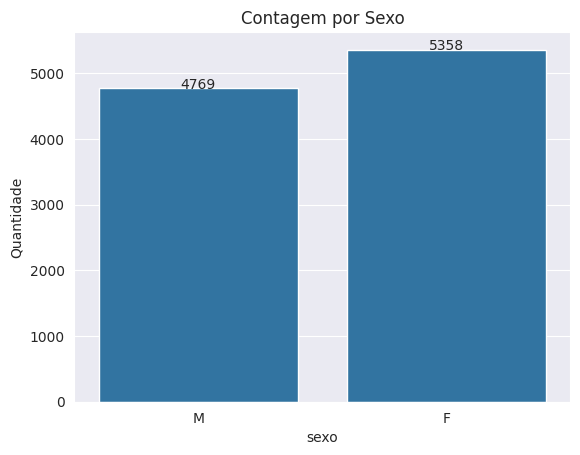

In [ ]:
with sns.axes_style('darkgrid'):
  ax = sns.countplot(df, x='sexo')
  plt.title('Contagem por Sexo')
  plt.ylabel('Quantidade')
  add_values_on_bars(ax)

Podemos observar uma mudança significativa: agora as mulheres predominam no dataset. No entanto, a diferença na quantidade de mulheres em relação aos homens não é tão grande quanto parecia anteriormente.

Vamos observar a quantidade de clientes por nível de cartão para entender melhor a distribuição no dataset completo.

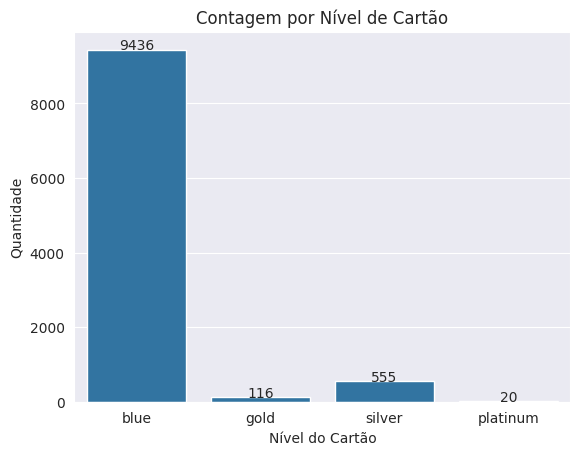

In [ ]:
with sns.axes_style('darkgrid'):
  ax = sns.countplot(df, x='tipo_cartao')
  plt.title('Contagem por Nível de Cartão')
  plt.ylabel('Quantidade')
  plt.xlabel('Nível do Cartão')
  add_values_on_bars(ax)

Em comparação com o dataset reduzido utilizado na parte da AWS, observamos um aumento significativo no número de clientes em todos os níveis de cartão, como já era de se esperar. No entanto, chama atenção o fato de que o nível Platinum apresentou o maior crescimento proporcional — embora não seja visualmente perceptível —, com uma quantidade de clientes dez vezes maior do que no conjunto de dados anterior.


Agora, vamos verificar se a predominância feminina observada anteriormente (na análise parcial com os dados da AWS) permanece no dataset completo. Isso nos ajudará a entender se aquela distribuição era uma tendência real ou apenas uma consequência do subconjunto reduzido dos dados.

In [ ]:
platinum_na = df[(df['tipo_cartao'] == 'platinum') & (df['salario_anual'] == 'na')]

platinum_na.head(20)

,id,default,idade,sexo,dependentes,escolaridade,estado_civil,salario_anual,tipo_cartao,meses_de_relacionamento,qtd_produtos,iteracoes_12m,meses_inativo_12m,limite_credito,valor_transacoes_12m,qtd_transacoes_12m
650,779519058,0,51,F,3,doutorado,divorciado,na,platinum,34,3,2,1,34516.96,1929.84,40
9068,719071158,1,54,F,0,mestrado,solteiro,na,platinum,38,2,2,2,34516.28,3901.40,54
9102,714190983,1,51,F,2,mestrado,solteiro,na,platinum,32,2,3,3,34516.81,5418.78,65
9127,713870958,0,56,F,3,sem educacao formal,solteiro,na,platinum,46,2,2,3,34516.98,8416.40,93
9858,714949758,0,51,F,3,mestrado,solteiro,na,platinum,42,3,4,1,34516.39,16712.29,123


Dos clientes de nível Platinum e supostamente sem renda fixa, todos são mulheres. Um ponto interessante é que quase todas possuem ensino superior e nenhuma delas está atualmente em um relacionamento.

Agora, vamos verificar se o padrão observado anteriormente — em que clientes com limite de crédito superior a R$30 mil não possuem salário anual declarado — também se repete no conjunto completo de dados. Isso poderá nos ajudar a entender se estamos diante de um comportamento recorrente ou apenas de alguns casos isolados.

In [ ]:
na_30k = df[(df['limite_credito'] > 30000) & (df['salario_anual'] == 'na')]

na_30k.head(10)

,id,default,idade,sexo,dependentes,escolaridade,estado_civil,salario_anual,tipo_cartao,meses_de_relacionamento,qtd_produtos,iteracoes_12m,meses_inativo_12m,limite_credito,valor_transacoes_12m,qtd_transacoes_12m
101,713843283,0,41,F,3,na,casado,na,silver,34,5,3,3,34516.81,1487.10,26
158,718759833,0,44,F,2,sem educacao formal,casado,na,silver,35,4,2,3,32643.83,1058.80,24
650,779519058,0,51,F,3,doutorado,divorciado,na,platinum,34,3,2,1,34516.96,1929.84,40
692,779558733,0,50,F,4,na,casado,na,silver,36,6,2,1,32156.29,1559.28,39
1277,709816158,0,31,F,1,na,solteiro,na,silver,36,4,2,3,34516.99,2183.71,60
1451,720009558,0,33,F,2,graduacao,solteiro,na,gold,36,3,3,1,34516.94,2574.80,72
1684,713484483,0,36,F,4,sem educacao formal,solteiro,na,silver,21,3,2,1,34516.05,2298.01,55
1925,771040758,0,62,F,0,mestrado,solteiro,na,silver,49,5,2,1,30310.45,3703.36,91
2096,708331758,0,47,F,2,sem educacao formal,divorciado,na,silver,35,3,4,1,32444.18,3725.59,60
2160,720639783,0,35,F,1,sem educacao formal,solteiro,na,silver,27,4,2,3,34516.26,2562.68,62


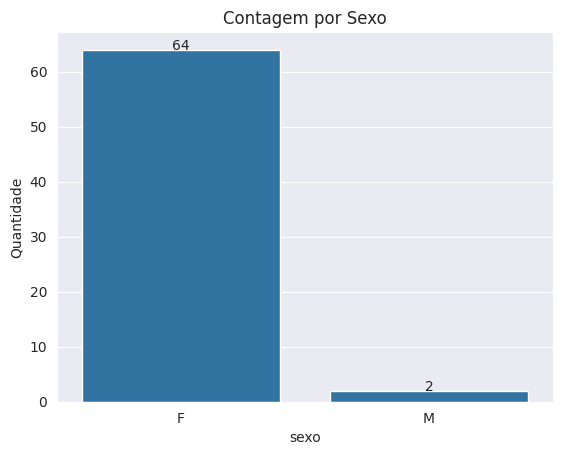

In [ ]:
with sns.axes_style('darkgrid'):
  ax = sns.countplot(na_30k, x='sexo')
  plt.title('Contagem por Sexo')
  plt.ylabel('Quantidade')
  add_values_on_bars(ax)

Claramente, os clientes do sexo feminino também se destacaram nesse recorte, mantendo o padrão observado anteriormente.

Antes de prosseguirmos para as conclusões finais, vamos analisar quais grupos apresentam gastos excessivos.

In [ ]:
sobre_gasto = df.query("limite_credito < valor_transacoes_12m")

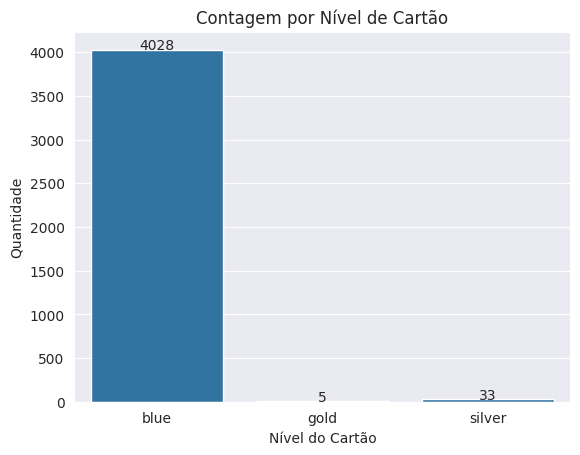

In [ ]:
with sns.axes_style('darkgrid'):
  ax = sns.countplot(sobre_gasto, x='tipo_cartao')
  plt.title('Contagem por Nível de Cartão')
  plt.xlabel('Nível do Cartão')
  plt.ylabel('Quantidade')
  add_values_on_bars(ax)

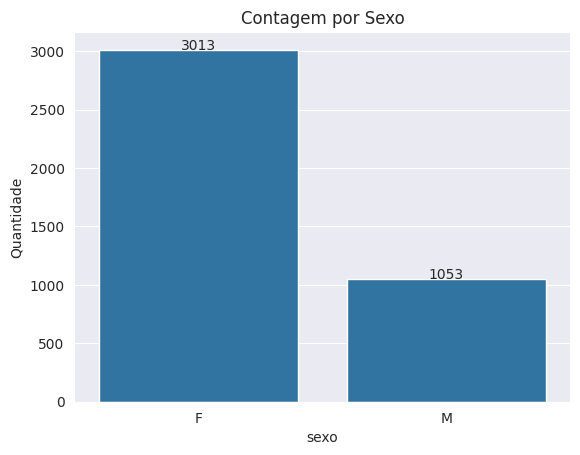

In [ ]:
with sns.axes_style('darkgrid'):
  ax = sns.countplot(sobre_gasto, x='sexo')
  plt.title('Contagem por Sexo')
  plt.ylabel('Quantidade')
  add_values_on_bars(ax)

Novamente, os clientes do nível Blue ultrapassaram seus limites de crédito. Contudo, o aspecto mais alarmante é a representatividade feminina nesse grupo: mais de 50% das clientes mulheres encontram-se em situação de gastos acima do permitido.

Agora, vamos seguir para os **insights finais**, onde reuniremos as principais descobertas e padrões identificados ao longo da análise.

# Insights Finais



*   Os clientes do sexo feminino demonstraram que, mesmo apresentando uma renda baixa (ou não declarada), ainda assim possuem um limite de crédito elevado. Isso pode ser explicado por alguns possíveis fatores:
  1.   **É empresária**: Apesar de não declarar uma renda fixa, pode possuir um negócio próprio, o que garante movimentação financeira suficiente para justificar um limite de crédito elevado.
  2.   **Possui um cônjuge** com alta renda: A situação financeira do parceiro(a) pode influenciar indiretamente na concessão de crédito, especialmente se houver vínculo financeiro entre eles.
  3.   **Fatores sociais**: O banco pode estar considerando variáveis sociais e comportamentais em sua análise de crédito, como escolaridade, estabilidade residencial, entre outros, que contribuam para uma avaliação positiva, mesmo sem renda declarada.
  4. Falhas no processo de verificação de renda.

*   Observamos que o público-alvo para a concessão de crédito — especialmente os limites mais elevados — tem sido majoritariamente o público feminino. No entanto, considerando que a proporção de clientes por sexo é relativamente equilibrada, com cerca de 50% sendo homens, essa abordagem pode estar limitando o potencial de crescimento da carteira de crédito.
Portanto, uma estratégia mais eficiente poderia ser direcionar esforços para aumentar o limite de crédito do público masculino. Ao fazer isso, o banco teria a oportunidade de explorar melhor uma fatia significativa da sua base de clientes que, até então, pode estar sendo subutilizada em termos de concessão de crédito.

*   O volume de clientes com gastos excessivos é crítico, indicando um risco significativo de inadimplência. Diante desse cenário, medidas imediatas são imprescindíveis para mitigar possíveis impactos financeiros. Possíveis soluções:
  1.   Implementar plano de renegociação de dívidas.
  2.   Desenvolver score de risco baseado em padrões de consumo e, para casos de alto risco, cancelamento do cartão.
  3.   Implementar medidas restritivas de uso do cartão.





